### Importing Modules

In [ ]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Categorical

from collections import namedtuple, deque
import datetime

import gym
from gym.wrappers.record_video import RecordVideo


import matplotlib.pyplot as plt

### Defining the two game environments

In [ ]:
#Defining Environments
#Environment 1

env1 = gym.make("Acrobot-v1")
#env1.seed(0)

env1_state_shape = env1.observation_space.shape[0]
env1_no_of_actions = env1.action_space.n

env1_state = env1.reset(seed = 0)


#Environment 2

env2 = gym.make("CartPole-v1")
#env2.seed(0)

env2_state_shape = env2.observation_space.shape[0]
env2_no_of_actions = env2.action_space.n

env2_state = env2.reset(seed = 0)


# Note For both Environments
# For choosing actions :
# action = env.action_space.sample()

# For step :
# next_state, reward, done, info = env.step(action)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
Transitions = namedtuple('Transitions', ['state', 'action', 'reward', 'next_state'])

class Policy(nn.Module):
  def __init__(self, state_size, action_size, seed, fc1_units = 128, fc2_units = 64):
    super(Policy, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.fc2 = nn.Linear(fc1_units, fc2_units)
    self.PI = nn.Linear(fc2_units, action_size)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    PI = F.softmax(self.PI(x), dim = -1)
    return PI

class Value(nn.Module):
  def __init__(self, state_size, seed, fc1_units = 128, fc2_units = 64):
    super(Value, self).__init__()
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.fc2 = nn.Linear(fc1_units, fc2_units)
    self.V = nn.Linear(fc2_units, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    V = self.V(x)
    return V

In [ ]:
class MC_Reinforce:
  def __init__(self, env, parameters, seed, id, Policy = Policy, Value = Value, gamma = 0.99, lr = 5e-4):
    self.env = env
    self.fc1, self.fc2 = parameters
    self.gamma = gamma
    self.lr = lr
    self.seed = seed
    self.id = id                             # id = 1 : Type 1, id = 2 : Type 2
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.n
    self.Policy = Policy(self.state_size, self.action_size, self.seed, self.fc1, self.fc2)
    self.Value = Value(self.state_size, self.seed, self.fc1, self.fc2)
    self.Policy_optimizer = optim.Adam(self.Policy.parameters(), lr = lr)
    self.Value_optimizer = optim.Adam(self.Value.parameters(), lr = lr)
    self.eps = np.finfo(np.float32).eps.item()

  def select_action(self, state):
    state = torch.from_numpy(state).float()
    pi = self.Policy(state)
    m = Categorical(pi)
    action = m.sample()
    return action

  def train(self, n_episodes = 1000):
    ep_returns = deque()
    scores = deque(maxlen = 100)
    for i in range(1, n_episodes + 1):
      state = self.env.reset()
      ep_reward = 0
      rewards = []
      transitions = []
      while True:
        action = self.select_action(state)
        next_state, reward, done, _ = self.env.step(action.item())
        transitions.append([state, action, reward, next_state])
        rewards.append(reward)
        ep_reward += reward
        if done:
          break
        state = next_state
      policy_losses = []
      value_losses = []
      returns = []
      R = 0
      for r in rewards[::-1]:
        R = r + self.gamma * R
        returns.insert(0, R)
      for j in range(len(transitions)):
        transition = transitions[j]
        return_1 = returns[j]
        state, action, reward, next_state = transition
        state = torch.from_numpy(state).float()
        next_state = torch.from_numpy(next_state).float()
        pi = self.Policy(state)
        m = Categorical(pi)
        if self.id == 1:
          policy_losses.append(- m.log_prob(action) * (return_1))
        else:
          policy_losses.append(- m.log_prob(action) * (return_1 - self.Value(state)))
        value_losses.append(F.mse_loss(reward + self.gamma * self.Value(next_state), self.Value(state)))
      p_loss = torch.stack(policy_losses).sum()
      v_loss = torch.stack(value_losses).sum()
      self.Policy_optimizer.zero_grad()
      p_loss.backward()
      self.Policy_optimizer.step()
      if self.id == 2:
        self.Value_optimizer.zero_grad()
        v_loss.backward()
        self.Value_optimizer.step()
      scores.append(ep_reward)
      R = 0
      for r in rewards:
        R = r + R
      print(f"Episode number {i}, and it's corresponding return is {R}, average rewards : {np.mean(scores)}")
      ep_returns.append(R)
    return list(ep_returns)

In [ ]:
returns_2_1_5runs = []
for seed in [0,1,2,3,4]:
    MC_2_1 = MC_Reinforce(env2, (128, 64), 0, 1)
    returns_2_1 = MC_2_1.train(1000)
    returns_2_1_5runs.append(returns_2_1)
returns_2_1_5runs = np.array(returns_2_1_5runs)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode number 1, and it's corresponding return is 18.0, average rewards : 18.0
Episode number 2, and it's corresponding return is 23.0, average rewards : 20.5
Episode number 3, and it's corresponding return is 21.0, average rewards : 20.666666666666668
Episode number 4, and it's corresponding return is 15.0, average rewards : 19.25
Episode number 5, and it's corresponding return is 16.0, average rewards : 18.6
Episode number 6, and it's corresponding return is 15.0, average rewards : 18.0
Episode number 7, and it's corresponding return is 20.0, average rewards : 18.285714285714285
Episode number 8, and it's corresponding return is 83.0, average rewards : 26.375
Episode number 9, and it's corresponding return is 22.0, average rewards : 25.88888888888889
Episode number 10, and it's corresponding return is 13.0, average rewards : 24.6
Episode number 11, and it's corresponding return is 18.0, average rewards : 24.0
Episode number 12, and it's corresponding return is 17.0, average rewards 

In [ ]:
returns_2_2_5runs = []
for seed in [0,1,2,3,4]:
    MC_2_2 = MC_Reinforce(env2, (128, 64), 0, 2)
    returns_2_2 = MC_2_2.train(1000)
    returns_2_2_5runs.append(returns_2_2)
returns_2_2_5runs = np.array(returns_2_2_5runs)

Episode number 1, and it's corresponding return is 15.0, average rewards : 15.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode number 2, and it's corresponding return is 30.0, average rewards : 22.5
Episode number 3, and it's corresponding return is 27.0, average rewards : 24.0
Episode number 4, and it's corresponding return is 11.0, average rewards : 20.75
Episode number 5, and it's corresponding return is 50.0, average rewards : 26.6
Episode number 6, and it's corresponding return is 13.0, average rewards : 24.333333333333332
Episode number 7, and it's corresponding return is 17.0, average rewards : 23.285714285714285
Episode number 8, and it's corresponding return is 15.0, average rewards : 22.25
Episode number 9, and it's corresponding return is 28.0, average rewards : 22.88888888888889
Episode number 10, and it's corresponding return is 31.0, average rewards : 23.7
Episode number 11, and it's corresponding return is 24.0, average rewards : 23.727272727272727
Episode number 12, and it's corresponding return is 10.0, average rewards : 22.583333333333332
Episode number 13, and it's corresponding retu

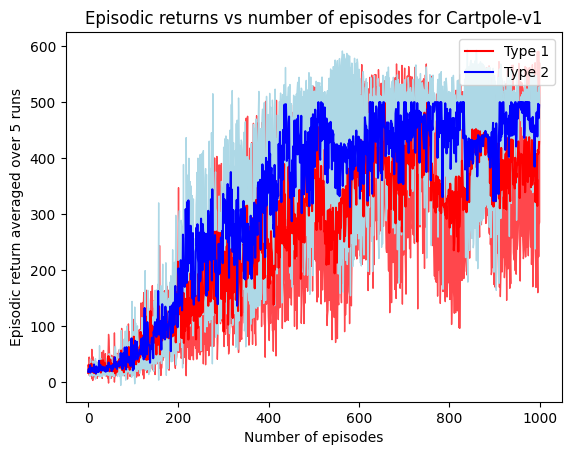

In [ ]:
n_episodes = np.arange(len(list(returns_2_1)))
avg_returns_env2_type_1 = np.mean(returns_2_1_5runs,axis = 0)
std_returns_env2_type_1 = np.std(returns_2_1_5runs,axis = 0)
avg_returns_env2_type_2 = np.mean(returns_2_2_5runs,axis = 0)
std_returns_env2_type_2 = np.std(returns_2_2_5runs,axis = 0)
plt.plot(n_episodes, avg_returns_env2_type_1, color = '#FF0000', label = "Type 1")
plt.plot(n_episodes, avg_returns_env2_type_2, color = '#0000FF', label = "Type 2")
plt.fill_between(n_episodes, avg_returns_env2_type_1 - std_returns_env2_type_1, avg_returns_env2_type_1 + std_returns_env2_type_1, color = '#FF474C')
plt.fill_between(n_episodes, avg_returns_env2_type_2 - std_returns_env2_type_2, avg_returns_env2_type_2 + std_returns_env2_type_2, color = '#ADD8E6')
plt.title("Episodic returns vs number of episodes for Cartpole-v1")
plt.xlabel("Number of episodes")
plt.ylabel("Episodic return averaged over 5 runs")
plt.legend()
plt.show()